In [1]:
from datetime import datetime

import time
import os
import sys
from pathlib import Path

import numpy as np
from scipy.stats import lognorm
import pandas as pd

from astropy import stats
from astropy.io import fits
from astropy.time import Time
import astropy.units as u

import matplotlib
#matplotlib.use('nbagg')
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

config = tf.ConfigProto()
sess = tf.Session(config=config)

np.random.seed(42)

print(tf.__version__)

1.14.0


In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

In [3]:
# load data and make some subsets for each wfs for inspection later
dfs = []
for y in [2018, 2019]:
    dfs.append(pd.read_csv(f"../raw_data/{y}_wfs.csv"))
data = pd.concat(dfs)
data['ut'] = pd.to_datetime(data.ut)
data['az'][data['az'] < 0.] += 360.

f9 = data[(data['wfs'] == 'newf9') | (data['wfs'] == 'oldf9')]
f5 = data[data['wfs'] == 'f5']
mmirs = data[data['wfs'] == 'mmirs']
bino = data[data['wfs'] == 'binospec']

/Users/tim/conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [4]:
f9.head()

,ut,airmass,az,cc_x_err,cc_y_err,chamt,el,exptime,file,focerr,...,tiltx,tilty,time,transx,transy,wavefront_rms,wfs,xcen,ycen,comaerr
0,2018-01-01 04:57:49.451,1.9576,53.573980,-2.245,-0.000,7.936,30.719296,10.0,f9wfs_20171231-215742.fits,-0.00,...,236.57,155.61,2018-01-01T04:57:49.451000,32.72,1220.11,212.297085,newf9,397.543854,429.949944,2.245000
1,2018-01-01 09:27:04.098,1.2180,145.107933,-1.101,-0.053,7.442,55.187501,10.0,f9wfs_20180101-022656.fits,-0.91,...,218.39,142.03,2018-01-01T09:27:04.098000,21.18,1115.73,228.040401,newf9,423.407744,436.401408,1.102275
2,2018-01-02 01:38:07.255,1.3693,216.426947,-0.163,0.000,8.255,46.911695,10.0,f9wfs_20180101-183759.fits,-7.98,...,204.89,156.26,2018-01-02T01:38:07.255000,-167.16,999.79,305.965461,newf9,404.742359,456.087836,0.163000
3,2018-01-02 02:12:02.759,1.3234,88.365503,-0.000,-2.910,7.780,49.080862,10.0,f9wfs_20180101-191154.fits,0.00,...,238.36,153.41,2018-01-02T02:12:02.759000,-105.48,1235.83,802.673998,newf9,409.654830,449.973043,2.910000
4,2018-01-03 01:29:05.750,1.3754,217.167150,-0.000,-4.944,8.181,46.641897,10.0,f9wfs_20180102-182856.fits,-8.20,...,198.05,156.66,2018-01-03T01:29:05.750000,-124.04,1041.43,327.751350,newf9,427.811790,439.718885,4.944000


In [5]:
data.columns

Index(['ut', 'airmass', 'az', 'cc_x_err', 'cc_y_err', 'chamt', 'el', 'exptime',
       'file', 'focerr', 'focus', 'fwhm', 'osst', 'outt', 'raw_seeing',
       'residual_rms', 'seeing', 'tiltx', 'tilty', 'time', 'transx', 'transy',
       'wavefront_rms', 'wfs', 'xcen', 'ycen', 'comaerr'],
      dtype='object')

In [6]:
# wrangle the times to add colums for mjd to look for trends over time and hour to look for nightly trends
raw_times = data['time']
times = Time(raw_times.values.tolist(), format='isot', scale='utc')
mjd = times.mjd
data['mjd'] = mjd.tolist()
data['hour'] = data['ut'].dt.hour
data.head()

,ut,airmass,az,cc_x_err,cc_y_err,chamt,el,exptime,file,focerr,...,time,transx,transy,wavefront_rms,wfs,xcen,ycen,comaerr,mjd,hour
0,2018-01-01 04:57:49.451,1.9576,53.573980,-2.245,-0.000,7.936,30.719296,10.0,f9wfs_20171231-215742.fits,-0.00,...,2018-01-01T04:57:49.451000,32.72,1220.11,212.297085,newf9,397.543854,429.949944,2.245000,58119.206822,4
1,2018-01-01 09:27:04.098,1.2180,145.107933,-1.101,-0.053,7.442,55.187501,10.0,f9wfs_20180101-022656.fits,-0.91,...,2018-01-01T09:27:04.098000,21.18,1115.73,228.040401,newf9,423.407744,436.401408,1.102275,58119.393797,9
2,2018-01-02 01:38:07.255,1.3693,216.426947,-0.163,0.000,8.255,46.911695,10.0,f9wfs_20180101-183759.fits,-7.98,...,2018-01-02T01:38:07.255000,-167.16,999.79,305.965461,newf9,404.742359,456.087836,0.163000,58120.068140,1
3,2018-01-02 02:12:02.759,1.3234,88.365503,-0.000,-2.910,7.780,49.080862,10.0,f9wfs_20180101-191154.fits,0.00,...,2018-01-02T02:12:02.759000,-105.48,1235.83,802.673998,newf9,409.654830,449.973043,2.910000,58120.091699,2
4,2018-01-03 01:29:05.750,1.3754,217.167150,-0.000,-4.944,8.181,46.641897,10.0,f9wfs_20180102-182856.fits,-8.20,...,2018-01-03T01:29:05.750000,-124.04,1041.43,327.751350,newf9,427.811790,439.718885,4.944000,58121.061872,1


In [7]:
e_series_2019 = pd.read_csv("../halcoll/data/halcoll_temps.csv")
e_series_2019.tail()

,ts,cell_e_series_backplate_C,cell_e_series_chamber_ambient_C,cell_e_series_frontplate_C,cell_e_series_in_front_of_primary_C,cell_e_series_lower_plenum_C,cell_e_series_midplate_C,cell_e_series_outside_ambient_C,yankee_temperature,temptrax1_probe2,temptrax1_probe3,temptrax1_probe4,temptrax1_probe6,temptrax3_probe10,temptrax3_probe11,temptrax3_probe12
390394,2019-09-17 12:50:00,14.1313,14.1071,14.0777,13.7032,14.2249,14.1307,13.3092,15.970,15.1,15.1,14.8,16.7,15.5,15.1,14.80
390395,2019-09-17 12:55:00,14.1313,14.1071,14.0777,13.7032,14.2249,14.1307,13.3092,16.002,15.1,15.1,14.9,16.7,15.5,15.1,14.80
390396,2019-09-17 13:00:00,14.1313,14.1071,14.0777,13.7032,14.2249,14.1307,13.3092,16.011,15.2,15.1,14.9,16.8,15.6,15.2,14.85
390397,2019-09-17 13:05:00,14.1313,14.1071,14.0777,13.7032,14.2249,14.1307,13.3092,16.069,15.2,15.2,14.9,16.8,15.6,15.2,14.90
390398,2019-09-17 13:10:00,14.1313,14.1071,14.0777,13.7032,14.2249,14.1307,13.3092,16.098,15.3,15.2,14.9,16.9,15.7,15.2,14.90


In [8]:
fixed = data.drop(columns=['ut']).set_index(pd.DatetimeIndex(data['time'], name='ut'))
fixed.head()

,airmass,az,cc_x_err,cc_y_err,chamt,el,exptime,file,focerr,focus,...,time,transx,transy,wavefront_rms,wfs,xcen,ycen,comaerr,mjd,hour
ut,,,,,,,,,,,,,,,,,,,,,
2018-01-01 04:57:49.451,1.9576,53.573980,-2.245,-0.000,7.936,30.719296,10.0,f9wfs_20171231-215742.fits,-0.00,404.58,...,2018-01-01T04:57:49.451000,32.72,1220.11,212.297085,newf9,397.543854,429.949944,2.245000,58119.206822,4
2018-01-01 09:27:04.098,1.2180,145.107933,-1.101,-0.053,7.442,55.187501,10.0,f9wfs_20180101-022656.fits,-0.91,832.62,...,2018-01-01T09:27:04.098000,21.18,1115.73,228.040401,newf9,423.407744,436.401408,1.102275,58119.393797,9
2018-01-02 01:38:07.255,1.3693,216.426947,-0.163,0.000,8.255,46.911695,10.0,f9wfs_20180101-183759.fits,-7.98,610.72,...,2018-01-02T01:38:07.255000,-167.16,999.79,305.965461,newf9,404.742359,456.087836,0.163000,58120.068140,1
2018-01-02 02:12:02.759,1.3234,88.365503,-0.000,-2.910,7.780,49.080862,10.0,f9wfs_20180101-191154.fits,0.00,665.59,...,2018-01-02T02:12:02.759000,-105.48,1235.83,802.673998,newf9,409.654830,449.973043,2.910000,58120.091699,2
2018-01-03 01:29:05.750,1.3754,217.167150,-0.000,-4.944,8.181,46.641897,10.0,f9wfs_20180102-182856.fits,-8.20,601.51,...,2018-01-03T01:29:05.750000,-124.04,1041.43,327.751350,newf9,427.811790,439.718885,4.944000,58121.061872,1


In [9]:
e_series = e_series_2019.set_index(pd.DatetimeIndex(e_series_2019['ts'], name='ut').tz_localize('MST').tz_convert(None)).drop(columns=['ts'])
e_series.head()

,cell_e_series_backplate_C,cell_e_series_chamber_ambient_C,cell_e_series_frontplate_C,cell_e_series_in_front_of_primary_C,cell_e_series_lower_plenum_C,cell_e_series_midplate_C,cell_e_series_outside_ambient_C,yankee_temperature,temptrax1_probe2,temptrax1_probe3,temptrax1_probe4,temptrax1_probe6,temptrax3_probe10,temptrax3_probe11,temptrax3_probe12
ut,,,,,,,,,,,,,,,
2016-01-01 07:00:00,1.82905,1.71735,1.7748,1.6990,1.78825,1.8217,1.54470,1.633,1.8,1.8,2.0,1.8,1.7,1.9,1.8
2016-01-01 07:05:00,1.82340,1.68600,1.7659,1.6806,1.76570,1.8120,1.53410,1.588,1.7,1.8,1.9,1.8,1.7,1.9,1.8
2016-01-01 07:10:00,1.82435,1.70410,1.7618,1.6727,1.75620,1.8087,1.52885,1.658,1.8,1.8,1.9,1.9,1.7,1.8,1.8
2016-01-01 07:15:00,1.81050,1.71710,1.7481,1.6543,1.75790,1.7965,1.54970,1.724,1.7,1.8,1.9,1.8,1.7,1.9,1.9
2016-01-01 07:20:00,1.81450,1.76420,1.7586,1.6753,1.78190,1.8041,1.61250,1.723,1.8,1.8,1.9,1.8,1.7,1.8,1.9


In [10]:
merged = pd.merge_asof(fixed.sort_index(), e_series, on='ut')
merged.head()

,ut,airmass,az,cc_x_err,cc_y_err,chamt,el,exptime,file,focerr,...,cell_e_series_midplate_C,cell_e_series_outside_ambient_C,yankee_temperature,temptrax1_probe2,temptrax1_probe3,temptrax1_probe4,temptrax1_probe6,temptrax3_probe10,temptrax3_probe11,temptrax3_probe12
0,2016-02-12 16:38:12.587,1.0258,253.778294,0.000,-0.646,5.654,77.130148,30.0,f9wfs_20181208-222048.fits,0.00,...,NaN,NaN,10.304,9.1,9.5,9.7,10.4,9.4,9.6,9.6
1,2016-02-12 16:40:42.278,1.0279,254.740639,-0.000,-0.000,5.713,76.617846,30.0,f9wfs_20181208-222318.fits,-14.25,...,NaN,NaN,10.344,9.2,9.6,9.7,10.4,9.4,9.6,9.7
2,2016-02-12 18:41:42.251,1.4602,266.228400,-3.798,-1.858,6.178,43.223068,30.0,f9wfs_20181209-002418.fits,2.42,...,NaN,NaN,11.589,10.3,10.5,10.2,12.1,10.6,10.3,10.2
3,2016-02-12 21:34:00.336,1.2782,126.225139,2.246,-1.496,5.208,51.476182,30.0,f9wfs_20181209-031636.fits,-12.67,...,NaN,NaN,13.287,12.1,12.2,11.4,14.1,12.6,12.2,11.5
4,2016-02-13 12:32:45.500,1.0422,266.183350,3.669,3.215,9.056,73.637676,30.0,f9wfs_20181209-181520.fits,-0.00,...,10.3693,8.6749,10.600,9.5,9.5,9.9,9.4,9.4,9.7,9.8


In [11]:
merged.columns

Index(['ut', 'airmass', 'az', 'cc_x_err', 'cc_y_err', 'chamt', 'el', 'exptime',
       'file', 'focerr', 'focus', 'fwhm', 'osst', 'outt', 'raw_seeing',
       'residual_rms', 'seeing', 'tiltx', 'tilty', 'time', 'transx', 'transy',
       'wavefront_rms', 'wfs', 'xcen', 'ycen', 'comaerr', 'mjd', 'hour',
       'cell_e_series_backplate_C', 'cell_e_series_chamber_ambient_C',
       'cell_e_series_frontplate_C', 'cell_e_series_in_front_of_primary_C',
       'cell_e_series_lower_plenum_C', 'cell_e_series_midplate_C',
       'cell_e_series_outside_ambient_C', 'yankee_temperature',
       'temptrax1_probe2', 'temptrax1_probe3', 'temptrax1_probe4',
       'temptrax1_probe6', 'temptrax3_probe10', 'temptrax3_probe11',
       'temptrax3_probe12'],
      dtype='object')

In [12]:
# trim out columns not relevant to training
trimmed = merged.drop(columns=['ut', 'time', 'airmass', 'cc_x_err', 'cc_y_err', 'chamt', 'osst', 'outt', 'exptime', 'file', 'focerr', 'fwhm', 'raw_seeing', 'residual_rms', 'seeing', 'wavefront_rms', 'xcen', 'ycen', 'comaerr'])
trimmed = trimmed.dropna()
trimmed.head()

,az,el,focus,tiltx,tilty,transx,transy,wfs,mjd,hour,...,cell_e_series_midplate_C,cell_e_series_outside_ambient_C,yankee_temperature,temptrax1_probe2,temptrax1_probe3,temptrax1_probe4,temptrax1_probe6,temptrax3_probe10,temptrax3_probe11,temptrax3_probe12
4,266.183350,73.637676,897.76,213.46,81.22,506.17,929.79,newf9,57431.522749,12,...,10.36930,8.67490,10.600,9.5,9.5,9.9,9.4,9.4,9.7,9.8
5,213.321035,62.412470,847.26,219.72,111.71,308.14,1071.90,newf9,57431.549230,13,...,10.53495,9.91065,9.823,9.3,9.4,9.8,9.1,9.3,9.9,9.9
8,53.573980,30.719296,404.58,236.57,155.61,32.72,1220.11,newf9,58119.206822,4,...,7.83530,7.28700,7.936,10.4,10.3,9.4,8.4,10.1,10.6,9.2
9,145.107933,55.187501,832.62,218.39,142.03,21.18,1115.73,newf9,58119.393797,9,...,7.27625,6.31325,7.522,6.6,6.9,7.3,6.6,6.6,7.1,7.3
10,216.426947,46.911695,610.72,204.89,156.26,-167.16,999.79,newf9,58120.068140,1,...,7.46960,8.02755,8.239,10.8,10.2,9.4,8.4,10.6,10.8,9.7


In [13]:
labels = ['focus', 'tiltx', 'tilty', 'transx', 'transy']

# assign columns for each wfs so we can use them as features for training
wfs = trimmed.pop('wfs')
trimmed['f9'] = ((wfs == 'newf9') | (wfs =='oldf9')) * 1
trimmed['f5'] = (wfs == 'f5') * 1
trimmed['mmirs'] = (wfs == 'mmirs') * 1
trimmed['bino'] = (wfs == 'binospec') * 1
trimmed = trimmed[(trimmed['hour'] > 0) & (trimmed['hour'] <= 13)]
trimmed

,az,el,focus,tiltx,tilty,transx,transy,mjd,hour,cell_e_series_backplate_C,...,temptrax1_probe3,temptrax1_probe4,temptrax1_probe6,temptrax3_probe10,temptrax3_probe11,temptrax3_probe12,f9,f5,mmirs,bino
4,266.183350,73.637676,897.76,213.46,81.22,506.17,929.79,57431.522749,12,10.33010,...,9.5,9.9,9.4,9.4,9.7,9.8,1,0,0,0
5,213.321035,62.412470,847.26,219.72,111.71,308.14,1071.90,57431.549230,13,10.51335,...,9.4,9.8,9.1,9.3,9.9,9.9,1,0,0,0
8,53.573980,30.719296,404.58,236.57,155.61,32.72,1220.11,58119.206822,4,7.84730,...,10.3,9.4,8.4,10.1,10.6,9.2,1,0,0,0
9,145.107933,55.187501,832.62,218.39,142.03,21.18,1115.73,58119.393797,9,7.30715,...,6.9,7.3,6.6,6.6,7.1,7.3,1,0,0,0
10,216.426947,46.911695,610.72,204.89,156.26,-167.16,999.79,58120.068140,1,7.36965,...,10.2,9.4,8.4,10.6,10.8,9.7,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29572,59.895839,61.559131,14424.95,287.73,174.73,-568.76,2562.70,58667.464912,11,15.30860,...,14.5,15.0,12.9,13.8,14.1,14.6,0,0,0,1
29573,59.858503,61.659252,14429.24,287.68,175.27,-568.55,2559.53,58667.465298,11,15.23925,...,14.4,14.9,12.9,13.7,14.1,14.5,0,0,0,1
29574,59.819343,61.762689,14433.04,287.20,175.11,-567.61,2557.18,58667.465682,11,15.23925,...,14.4,14.9,12.9,13.7,14.1,14.5,0,0,0,1
29575,59.780150,61.865064,14434.63,286.97,175.04,-566.22,2554.41,58667.466067,11,15.23925,...,14.4,14.9,12.9,13.7,14.1,14.5,0,0,0,1


In [14]:
# the large range in offsets is messing up the training. so normalize the hexapod coords to their means
means = {}
for w in ['f5', 'f9', 'mmirs', 'bino']:
    means[w] = {}
for l in labels:
    # f/5 and bino are optically the same and have very similar mean hexapod coords
    means['f5'][l] = trimmed[(trimmed['f5'] == 1) | (trimmed['bino'] == 1)][l].mean()
    means['bino'][l] = means['f5'][l]
    means['mmirs'][l] = trimmed[trimmed['mmirs'] == 1][l].mean()
    means['f9'][l] = trimmed[trimmed['f9'] == 1][l].mean()

for k in means:
    for l in labels:
        trimmed[l][trimmed[k] == 1] -= means[k][l]
trimmed

/Users/tim/conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,az,el,focus,tiltx,tilty,transx,transy,mjd,hour,cell_e_series_backplate_C,...,temptrax1_probe3,temptrax1_probe4,temptrax1_probe6,temptrax3_probe10,temptrax3_probe11,temptrax3_probe12,f9,f5,mmirs,bino
4,266.183350,73.637676,95.780034,-9.922290,-47.733939,386.758620,-132.130505,57431.522749,12,10.33010,...,9.5,9.9,9.4,9.4,9.7,9.8,1,0,0,0
5,213.321035,62.412470,45.280034,-3.662290,-17.243939,188.728620,9.979495,57431.549230,13,10.51335,...,9.4,9.8,9.1,9.3,9.9,9.9,1,0,0,0
8,53.573980,30.719296,-397.399966,13.187710,26.656061,-86.691380,158.189495,58119.206822,4,7.84730,...,10.3,9.4,8.4,10.1,10.6,9.2,1,0,0,0
9,145.107933,55.187501,30.640034,-4.992290,13.076061,-98.231380,53.809495,58119.393797,9,7.30715,...,6.9,7.3,6.6,6.6,7.1,7.3,1,0,0,0
10,216.426947,46.911695,-191.259966,-18.492290,27.306061,-286.571380,-62.130505,58120.068140,1,7.36965,...,10.2,9.4,8.4,10.6,10.8,9.7,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29572,59.895839,61.559131,-104.230914,11.502123,25.459842,-398.075746,-115.149150,58667.464912,11,15.30860,...,14.5,15.0,12.9,13.8,14.1,14.6,0,0,0,1
29573,59.858503,61.659252,-99.940914,11.452123,25.999842,-397.865746,-118.319150,58667.465298,11,15.23925,...,14.4,14.9,12.9,13.7,14.1,14.5,0,0,0,1
29574,59.819343,61.762689,-96.140914,10.972123,25.839842,-396.925746,-120.669150,58667.465682,11,15.23925,...,14.4,14.9,12.9,13.7,14.1,14.5,0,0,0,1
29575,59.780150,61.865064,-94.550914,10.742123,25.769842,-395.535746,-123.439150,58667.466067,11,15.23925,...,14.4,14.9,12.9,13.7,14.1,14.5,0,0,0,1


In [15]:
train_dataset = trimmed.sample(frac=0.8, random_state=0)
test_dataset = trimmed.drop(train_dataset.index)

train_stats = train_dataset.describe()
train_stats = train_stats.drop(columns=labels)
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
az,23502.0,216.255125,102.038842,0.065961,145.337893,224.547229,309.214130,372.285517
el,23502.0,55.692482,11.560174,14.999996,47.958765,54.474907,62.770867,88.970000
mjd,23502.0,58479.289179,135.103588,57431.522749,58425.284688,58473.307650,58592.012274,58667.466451
hour,23502.0,6.716960,2.767959,1.000000,5.000000,7.000000,9.000000,13.000000
cell_e_series_backplate_C,23502.0,8.796433,4.760725,-3.317400,5.582300,7.861000,11.410213,21.122100
cell_e_series_chamber_ambient_C,23502.0,9.000489,4.795795,-5.107800,6.133525,7.975600,11.224950,20.709300
cell_e_series_frontplate_C,23502.0,8.784783,4.769006,-3.383200,5.660100,7.807600,11.376150,21.100000
cell_e_series_in_front_of_primary_C,23502.0,8.592884,4.834486,-3.637200,5.667300,7.623000,10.933000,21.657400
cell_e_series_lower_plenum_C,23502.0,8.717133,4.743307,-3.630300,5.468250,7.761700,11.248600,20.468200
cell_e_series_midplate_C,23502.0,8.759170,4.768464,-3.266900,5.538000,7.826700,11.362200,20.891100


In [16]:
train_labels = {}
test_labels = {}
for l in labels:
    train_labels[l] = train_dataset.pop(l)
    test_labels[l] = test_dataset.pop(l)

In [17]:
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [18]:
def build_model():
    model = keras.Sequential([
        layers.Dense(32, activation=tf.nn.relu, input_shape=[len(train_dataset.keys())]),
        layers.Dense(32, activation=tf.nn.relu),
        layers.Dense(32, activation=tf.nn.relu),
        layers.Dense(1)
    ])

    optimizer = tf.keras.optimizers.RMSprop(0.001)

    model.compile(
        loss='mean_squared_error',
        optimizer=optimizer,
        metrics=['mean_absolute_error', 'mean_squared_error']
    )
    return model

In [19]:
models = {}
for l in labels:
    models[l] = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=400)

W0918 19:30:21.330930 4493530560 deprecation.py:506] From /Users/tim/conda/envs/py37/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [20]:
models['focus'].summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                768       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 2,913
Trainable params: 2,913
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: 
            print('')
        print('.', end='')

EPOCHS = 8000

histories = {}

for l in labels:
    print(f"Training {l} model....")
    histories[l] = models[l].fit(
        normed_train_data, train_labels[l],
        epochs=EPOCHS, validation_split = 0.2, verbose=0,
        callbacks=[early_stop, PrintDot()]
    )
    print("\n")

Training focus model....


In [27]:
for l in labels:
    models[l].save(f"../halcoll/data/{l}_alldata_32x32x32_model.h5")

In [22]:
def plot_history(history, label=None):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error')
    plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
    plt.legend()
    if label is not None:
        plt.title(label)

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error')
    plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
    plt.legend()
    if label is not None:
        plt.title(label)
    plt.savefig(f"{label}_train.pdf")
    plt.show()

<IPython.core.display.Javascript object>


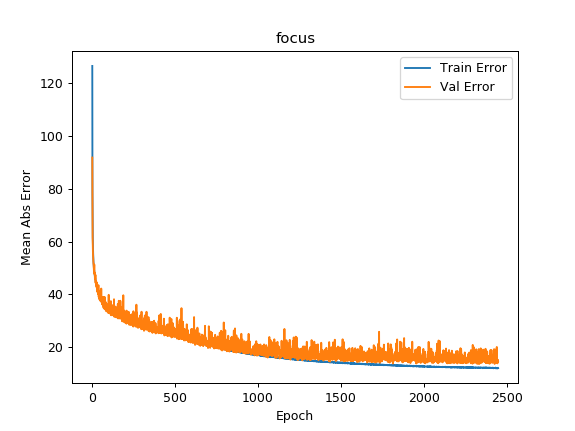

<IPython.core.display.Javascript object>


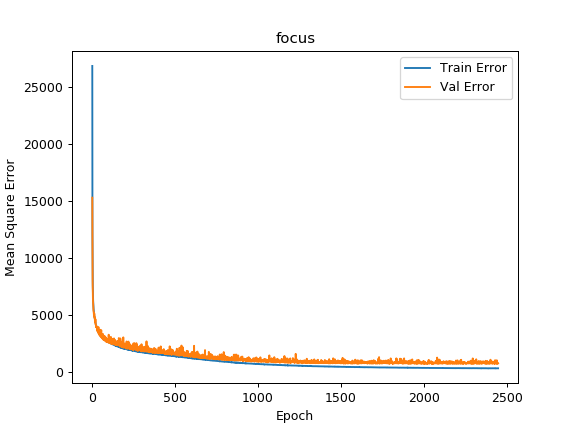

In [28]:
plot_history(histories['focus'], label="focus")

In [24]:
def show_results(label):
    loss, mae, mse = models[label].evaluate(normed_test_data, test_labels[label], verbose=0)

    print("Testing set Mean Abs Error: {:5.2f} um".format(mae))
    print("Testing set RMS: {:5.2f} um".format(np.sqrt(mse)))

    test_predictions = models[label].predict(normed_test_data).flatten()

    plt.scatter(test_labels[label], test_labels[label] - test_predictions)
    plt.xlabel('True Values [um]')
    plt.ylabel('Residuals [um]')
    minx, maxx = min(test_labels[label]), max(test_labels[label])
    plt.plot([minx, maxx], [0, 0])
    plt.show()

Testing set Mean Abs Error: 15.10 um
Testing set RMS: 30.31 um


<IPython.core.display.Javascript object>


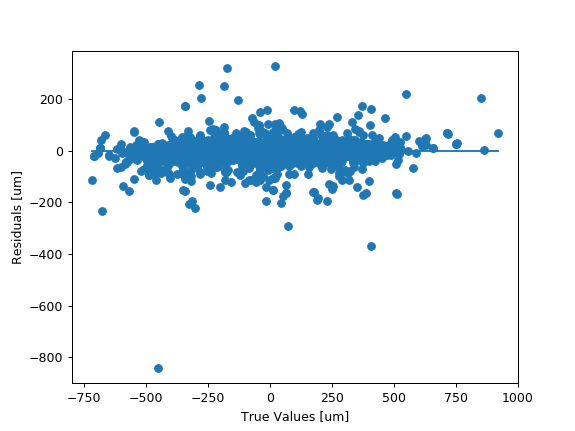

In [26]:
show_results('focus')

In [29]:
lab = 'focus'
test_predictions = models[lab].predict(normed_test_data).flatten()
diff = test_labels[lab] - test_predictions
diff.idxmax(), diff.idxmin()

(5183, 23618)

In [ ]:
test_labels[lab].idxmin()

In [30]:
test_dataset.loc[23618]

az                                        90.760000
el                                        37.470000
mjd                                    58535.089722
hour                                       2.000000
cell_e_series_backplate_C                  1.127000
cell_e_series_chamber_ambient_C           -5.107800
cell_e_series_frontplate_C                 0.377000
cell_e_series_in_front_of_primary_C       -0.702000
cell_e_series_lower_plenum_C              -0.239100
cell_e_series_midplate_C                   0.591600
cell_e_series_outside_ambient_C           -5.919400
yankee_temperature                        -4.085500
temptrax1_probe2                           4.350000
temptrax1_probe3                           3.200000
temptrax1_probe4                           1.600000
temptrax1_probe6                          -4.000000
temptrax3_probe10                          3.500000
temptrax3_probe11                          0.900000
temptrax3_probe12                          0.000000
f9          

In [ ]:
chk_data = normed_test_data[normed_test_data['f9'] > 0]
#chk.index
chk_test = test_labels['focus'][chk_data.index] 
chk_pred = models['focus'].predict(chk_data).flatten()
chk_diff = chk_test - chk_pred
chk_diff.std()

In [ ]:
chk_diff

In [ ]:
test_dataset.loc[3125]

In [ ]:
m = keras.models.load_model("/Users/tim/MMT/HALcoll/halcoll/data/tiltx_model.h5")

In [ ]:
m.evaluate(normed_test_data, test_labels['tiltx'])

In [ ]:
ttt = train_dataset['cell_e_series_chamber_ambient_C'] - train_dataset['yankee_temperature']
ttt.min()

In [ ]:
m = models['focus']

In [ ]:
m.summary()